In [3]:
import os
import time
from pathlib import Path
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, Input, metrics

## Prepare demo data

Input data include both waveform data (X) and P/S ratio data (ps), and label saved in the y.  

In [2]:
data = np.load('./demo_data/demo_data.npz')

# training data samples
X_train=data['X_train'] 
ps_train=data['ps_train'] 
y_train=data['y_train'] 

# validation data samples
X_val=data['X_val']
ps_val=data['ps_val'] 
y_val=data['y_val']

# test data samples
X_test=data['X_test']
ps_test=data['ps_test'] 
y_test=data['y_test'] 

print(f"There are {len(X_train)} training, {len(X_val)} validation and {len(X_test)} test data")
print(f"training waveform data shape {X_train.shape}")
print(f"training p/s data shape {ps_train.shape}")

There are 200 training, 50 validation and 50 test data
training waveform data shape (200, 2000, 1, 3)
training p/s data shape (200,)


In [4]:
# prepare the class weights to weight more of the minor class
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights = {0:class_weights[0].astype(np.float32), 1:class_weights[1].astype(np.float32)}
class_weights

{0: 0.96153843, 1: 1.0416666}

In [5]:
batch_size = 256

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices({"X": X_train, "ps": ps_train, "y":y_train})
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices({"X": X_val, "ps": ps_val, "y":y_val})
val_dataset = val_dataset.shuffle(buffer_size=len(X_val)).batch(batch_size)

# Prepare the test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices({"X": X_test, "ps": ps_test, "y":y_test})
test_dataset = test_dataset.batch(batch_size)

## Define model

Here we define a basic CNN model for binary classification

In [6]:
def build_model(input_shape = (2000, 1, 3),
                kernel_size = (3, 1),
                pooling_size = (2, 1),
                root_filters = 16,
                clip_filters = None,
                dense_dropout = 0.3,
                cnn_dropout = 0.1,
                n_layers = 4,
                activation='relu',
                output_class = 2,
                output_activation='softmax'
                ):
    
    # build cnn layers
    inputs = Input(shape=input_shape)

    y = layers.Conv2D(filters=root_filters,
         kernel_size=kernel_size,
         activation=activation, padding="same")(inputs)
    y = layers.MaxPooling2D(pooling_size)(y)
    n_kernels = root_filters
    for i in range(n_layers):

        if clip_filters:
            if n_kernels > clip_filters:
                n_kernels = clip_filters
            else:
                n_kernels *= 2
        else:
            n_kernels *= 2
                
        y = layers.Conv2D(filters=n_kernels,
         kernel_size=kernel_size,padding="same",
                         activation=activation)(y)
        y = layers.Dropout(cnn_dropout)(y)
        y = layers.MaxPooling2D(pooling_size)(y)

    # convert image to vector 
    y = layers.Flatten()(y)
    # dropout regularization
    y = layers.Dropout(dense_dropout)(y)
    y = layers.Dense(100, activation=activation)(y)
    outputs = layers.Dense(output_class, activation=output_activation)(y)
     # model building by supplying inputs/outputs
    model = models.Model(inputs=inputs, outputs=outputs)
    model.summary()

    return model

## Define loss function

For loss, we have two components, the data driven loss, which is *get_sparsecategoricalEntropy* and the physics loss, which is the *get_physicsConsistency*. We combine them using weights lambda_dl (deep learning loss) and lambda_phy (physics loss). 

In [7]:
from tensorflow.keras.activations import relu

def get_sparsecategoricalEntropy(y_true, y_pred, weights=1):
    # get the deep learning loss based on data and estimation
    cee = tf.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return tf.reduce_mean(cee*weights)


def get_physicsConsistency(ps_ratio, y_true, y_pred, ps_ratio_threshold=1.0, class_weights=1):
    
    # since label of earthquake is 1 and explosion is 0
    phy_est = tf.cast(ps_ratio < ps_ratio_threshold, tf.float32)
    
    # let's measure inconsistency
    loss_phy = tf.losses.sparse_categorical_crossentropy(phy_est, y_pred)
        
    return tf.reduce_mean(loss_phy*class_weights)



def compute_loss(y_pred, X_batch, y_true, ps_batch,
                 class_weights=None, lambda_dl=1, lambda_phy=1):
    
    weights = 1
    if class_weights:
        # get the weight matrix
        weights = tf.ones(ps_batch.shape) 
        for label in [0, 1]:
            weights = tf.where(y_true != label, weights, class_weights[label]) 
    loss_dl = get_sparsecategoricalEntropy(y_true, y_pred, weights)
    loss_phy = get_physicsConsistency(ps_batch, y_true, y_pred, ps_ratio_threshold = 1.0, class_weights=weights)
    
    return lambda_dl*loss_dl + lambda_phy*loss_phy, lambda_dl*loss_dl, lambda_phy*loss_phy


## Training

Training is done using the gradient of the combined loss. 

In [8]:
@tf.function
def train_step(x, y, ps, class_weights, lambda_dl, lambda_phy):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        loss_value, loss_dl, loss_phy = compute_loss(y_pred, x, y, ps, 
                                                     class_weights, 
                                                     lambda_dl, 
                                                     lambda_phy)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    #for var, g in zip(model.trainable_variables, grads):
    #    print(f'{var.name}, shape: {tf.reduce_sum(g*g)}')
    acc = metrics.sparse_categorical_accuracy(y, y_pred)
    acc = tf.reduce_sum(acc) / len(acc)
    return loss_value, loss_dl, loss_phy, acc

@tf.function
def val_step(x, y, ps, class_weights, lambda_dl, lambda_phy):
    y_pred = model(x, training=False)
    loss_value, loss_dl, loss_phy = compute_loss(y_pred, x, y, ps, 
                                                 class_weights, 
                                                     lambda_dl, 
                                                     lambda_phy)
    
    acc = metrics.sparse_categorical_accuracy(y, y_pred)
    acc = tf.reduce_sum(acc) / len(acc)
    return loss_value, loss_dl, loss_phy, acc

def train_and_validation(dataset, train_flag,
                         class_weights, lambda_dl, lambda_phy):
    
    loss_all_epoch = 0
    loss_dl_epoch = 0
    loss_phy_epoch = 0
    acc_epoch = 0
    
    for step, batch in enumerate(dataset):
        x_batch, ps_batch, y_batch = batch['X'], batch['ps'], batch['y']
        if train_flag:
            loss_all_batch, loss_dl_batch, loss_phy_batch, acc_batch = train_step(
                x=x_batch, y=y_batch, ps=ps_batch, class_weights=class_weights,
                lambda_dl=lambda_dl, lambda_phy=lambda_phy)
        else:
            loss_all_batch, loss_dl_batch, loss_phy_batch, acc_batch = val_step(
                x=x_batch, y=y_batch, ps=ps_batch, class_weights=class_weights,
                lambda_dl=lambda_dl, lambda_phy=lambda_phy)
        
        loss_all_epoch += loss_all_batch.numpy()
        loss_dl_epoch += loss_dl_batch.numpy()
        loss_phy_epoch += loss_phy_batch.numpy()
        acc_epoch += acc_batch.numpy()
    n = step + 1
    loss_all_epoch /= n  
    loss_dl_epoch /= n 
    loss_phy_epoch /= n 
    acc_epoch /= n
    
    return loss_all_epoch, loss_dl_epoch, loss_phy_epoch, acc_epoch

In [ ]:
tf.keras.backend.clear_session()

model_version = '1'

lambda_dl = 1
lambda_phy = 1

output_location = f'./trained_models/dl_{lambda_dl}_phy_{lambda_phy}_ver{model_version}'
Path(output_location).mkdir(parents=True, exist_ok=True)

epochs = 1000
lr = 0.001


# Choose the optimizer
optimizer = tf.keras.optimizers.Adam()
# initialize the training history
history = defaultdict(list)

early_stopping_count = 0
patience = 10

monitor = 'val_acc'

cur_val_loss = 1000000
cur_val_acc = 0

model = build_model(root_filters = 64,
                        dense_dropout = 0.5,
                        cnn_dropout = 0.3,
                        n_layers = 2,
                        pooling_size = (4, 1)
                        )

for epoch in range(epochs):
    start_time = time.time()

    # Training step
    loss_all_epoch_train, loss_dl_epoch_train, loss_phy_epoch_train, acc_train = train_and_validation(
        train_dataset, train_flag=True, class_weights=class_weights,
        lambda_dl=lambda_dl, lambda_phy=lambda_phy)

    # Validation step
    loss_all_epoch_val, loss_dl_epoch_val, loss_phy_epoch_val, acc_val = train_and_validation(
        val_dataset, train_flag=False, class_weights=class_weights,
        lambda_dl=lambda_dl, lambda_phy=lambda_phy)

    print(f"Epoch {epoch}: time used {time.time() - start_time:.2f}s"
          f"    Loss for train all: {loss_all_epoch_train:.4f}, val all: {loss_all_epoch_val:.4f}\n"
          f"    Accuracy for train: {acc_train:.4f}, validation: {acc_val:.4f}\n"
          f"    Loss for DL_train: {loss_dl_epoch_train:.4f}, DL_val: {loss_dl_epoch_val:.4f}\n"
          f"    Loss for Phy_train {loss_phy_epoch_train:.4f}, Phy_val: {loss_phy_epoch_val:.4f}\n")
    
    history['train_loss_all'].append(loss_all_epoch_train)
    history['train_loss_dl'].append(loss_dl_epoch_train)
    history['train_loss_phy'].append(loss_phy_epoch_train)
    history['train_acc'].append(acc_train)
    
    history['val_loss_all'].append(loss_all_epoch_val)
    history['val_loss_dl'].append(loss_dl_epoch_val)
    history['val_loss_phy'].append(loss_phy_epoch_val)
    history['val_acc'].append(acc_val)
    
    history['epoch_time'].append(time.time() - start_time)
    
    
    if monitor == 'val_loss':
        if loss_all_epoch_val < cur_val_loss:
            # Note: we are watching val loss to save models
            cur_val_loss = loss_all_epoch_val
            print(f"Model saved at epoch {epoch} to {output_location}")
            model_path = os.path.join(output_location, f'best_model.hdf5')
            tf.keras.models.save_model(model, model_path)
            history['best_model_epochs'].append(epoch)
            # update the history pkl whenever we save the results
            early_stopping_count = 0
        else:
            early_stopping_count += 1
    else:
        if acc_val > cur_val_acc:
            # Note: we are watching val loss to save models
            cur_val_acc = acc_val
            print(f"Model saved at epoch {epoch} to {output_location}")
            model_path = os.path.join(output_location, f'best_model.hdf5')
            tf.keras.models.save_model(model, model_path)
            history['best_model_epochs'].append(epoch)
            # update the history pkl whenever we save the results
            early_stopping_count = 0
        else:
            early_stopping_count += 1
        
    if early_stopping_count >= patience:
        print("################")
        print(f"Finish training at epoch {epoch} after waiting {early_stopping_count} epoch without improvement!")
        break

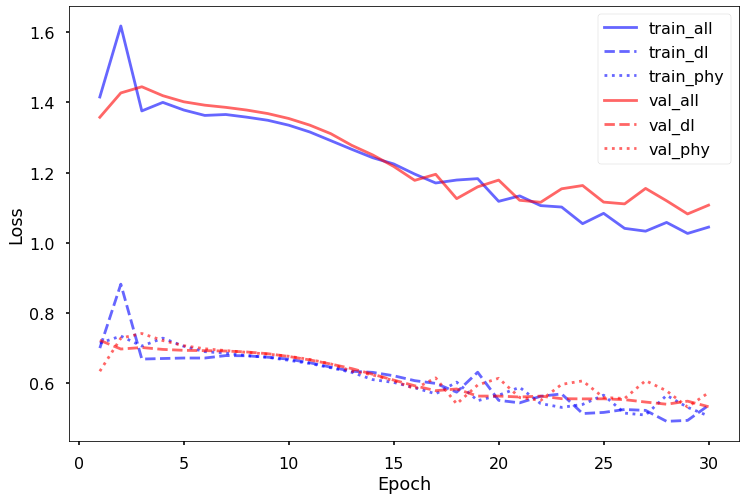

In [9]:
alpha = 0.6
epochs=len(history['train_loss_all'])
plt.figure(figsize=(12, 8))
epoch = np.arange(1, epochs+1)
plt.plot(epoch, history['train_loss_all'], 'b', label='train_all', alpha=alpha)
plt.plot(epoch, history['train_loss_dl'], 'b--', label='train_dl', alpha=alpha)
plt.plot(epoch, history['train_loss_phy'], 'b:', label='train_phy', alpha=alpha)

plt.plot(epoch, history['val_loss_all'], 'r', label='val_all', alpha=alpha)
plt.plot(epoch, history['val_loss_dl'], 'r--', label='val_dl', alpha=alpha)
plt.plot(epoch, history['val_loss_phy'], 'r:', label='val_phy', alpha=alpha)
#plt.xlim(0, 30)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim(0, 1)
plt.show();

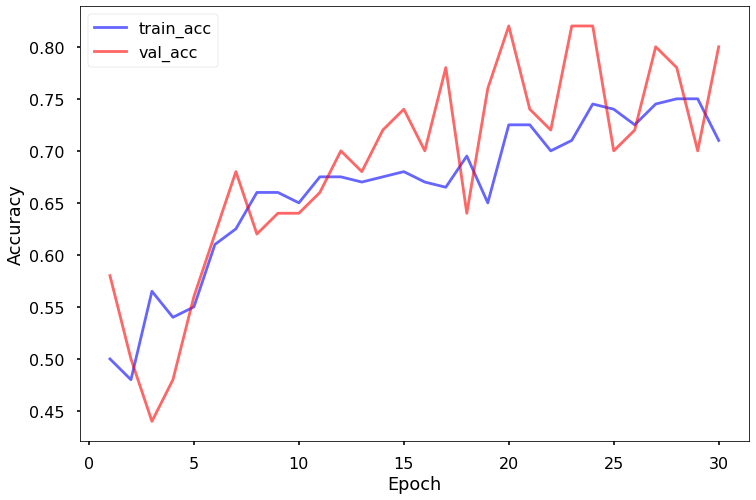

In [10]:
alpha = 0.6

plt.figure(figsize=(12, 8))
plt.plot(epoch, history['train_acc'], 'b', label='train_acc', alpha=alpha)

plt.plot(epoch, history['val_acc'], 'r', label='val_acc', alpha=alpha)

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();